# Calculate and visualize GlobalScat imaging performance

In [1]:
# This is for development purposes. Should bre removed before deployment
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import date
import os

import numpy as np
import matplotlib.pyplot as plt

from drama.io import cfg
import drama.constants as cnsts
# from drama.performance.sar.sar_performance_common import calc_analysis_time
from drama.performance.sar import (
    calc_aasr,
    calc_nesz,
    RASR,
    RASRdata,
    pattern,
    AASRdata,
    NESZdata,
    SARModeFromCfg,
)
from drama.performance.sar.azimuth_performance import mode_from_conf

## Set up the directories and simulation parametrs


In [3]:
# General setup
# main_dir = Path("~/Code/KappaZeta/").expanduser()
plt_dir = 'C:/Users/Jelle/Desktop/Msc Space Engineering/Earth Observation/Radar Assignment/plots'
main_dir = 'C:/Users/Jelle/Desktop/Msc Space Engineering/Earth Observation/Radar Assignment'
#data_dir = main_dir / "Data"
data_dir = 'C:/Users/Jelle/Desktop/Msc Space Engineering/Earth Observation/Radar Assignment/Results'
pattern_dir = os.path.join(data_dir, "Patterns")
rxname = "global_scat"
txname = "global_scat"
# Next two lines are for Sentinel-1 performance
# rxname = 'sentinel'
# For companions, is_bistatic should be True
is_bistatic = False
run_id = "2025_01"
par_dir = os.path.join(main_dir) #Removed PAR
plot_dir =os.path.join(data_dir, "Activation", run_id, date.today().isoformat())
par_file = os.path.join(par_dir, "GlobalScat.cfg")
conf = cfg.ConfigFile(par_file)
# extract relevant info from conf
rxcnf = getattr(conf, rxname)
txcnf = getattr(conf, txname)
if is_bistatic:
    dau_km = int(conf.formation_primary.dau[0] / 1e3)
else:
    dau_km = int(0)
dau_str = "%ikm" % dau_km
indstr = rxname
sysid = indstr  # ("%s_%3.2fm" % (indstr, b_at))
if rxcnf.az_steer:
    sysid = sysid + "_az_steer"
if rxcnf.DBF:
    sysid = sysid + "_DBF"
if rxcnf.SCORE:
    sysid = sysid + "_SCORE"

save_dir = os.path.join(data_dir, "SARPERF", sysid)
save_dir = os.path.join(save_dir, dau_str)
mode = "stripmap"
Nswth = 1
n_az_pts = 11
inc_range = [10, 45]
(
    incs,
    PRFs,
    proc_bw,
    steering_rates,
    burst_lengths,
    short_name,
    proc_tap,
    tau_p,
    bw_p,
) = mode_from_conf(conf, mode)

ValueError: could not convert string to float: ''

# Set up GlobalScat parameters

# Azimuth Ambiguities

GeoHistory -- Total initialization time: 0.869176
calc_aasr -- Compute Patterns
calc_aasr -- Steering rates: 0.000000, 0.000000


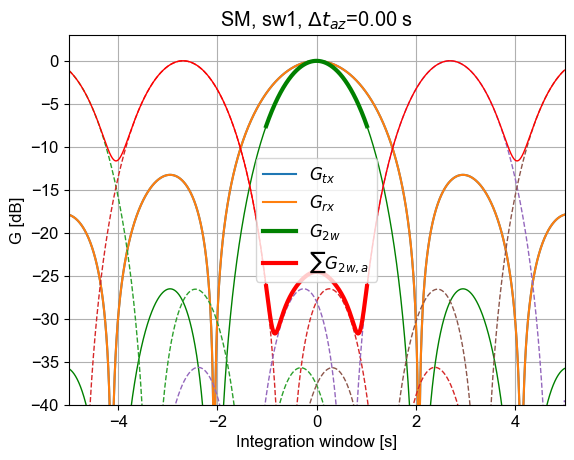

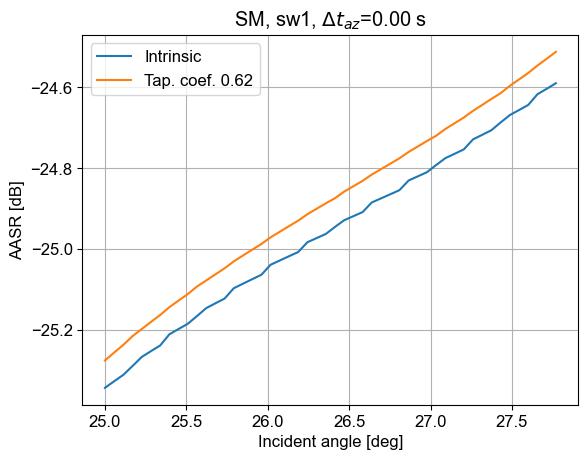

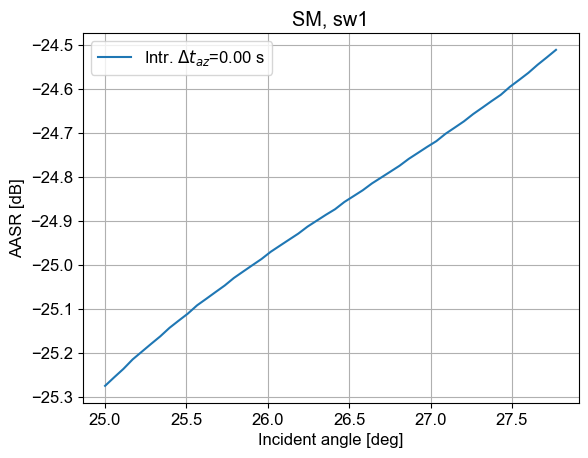

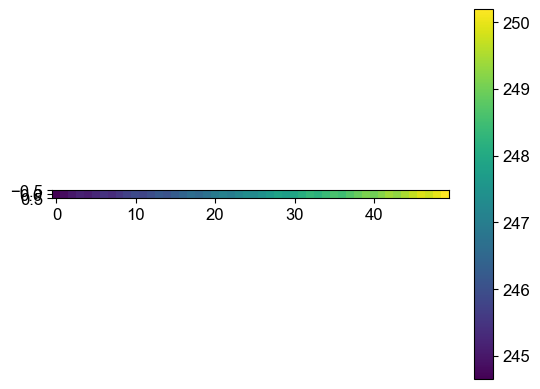

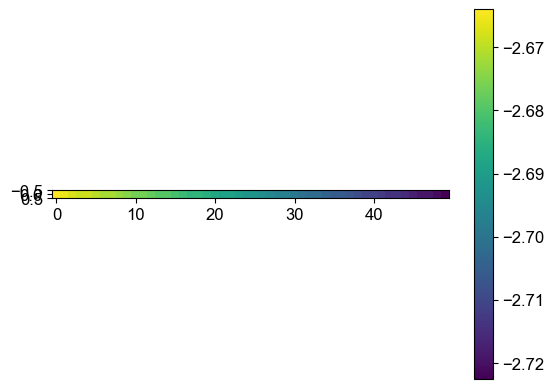

In [ ]:
do_aasrs = True

aasrs = []
aasr_files = []
# t_analysis = calc_analysis_time(conf.orbit.Horb, np.radians(35), 5.4e9, 2000, n_amb=0, r_planet=cnsts.r_moon, gm_planet=cnsts.gm_moon)
for swth in range(Nswth):
    modeandswth = "%s_sw%i" % (short_name, swth + 1)
    modedir = os.path.join(save_dir, modeandswth)
    aasr_files.append(os.path.join(modedir, "aasr.p"))
    if do_aasrs:
        aasr_ = calc_aasr(
            conf,
            mode,
            swth,
            txname=txname,
            rxname=rxname,
            savedirr=save_dir,
            t_in_bs=[0],  # For stripmap we only need one value
            n_az_pts=1,
            view_patterns=False,
            # Tanalysis=t_analysis+2,
            t_span_pattern=10,
            az_sampling=600,
            Namb=2,
            bistatic=is_bistatic,
            # r_planet=cnsts.r_moon,
            # gm_planet=cnsts.gm_moon,
            # aei = (cnsts.r_moon + conf.orbit.Horb, 0, 90), # This overrides orbit determination
            # ellipsoid = [cnsts.r_moon,cnsts.r_moon,cnsts.r_moon],
            # orb_type="free"
        )
        aasr_.save(os.path.join(modedir, "aasr.p"))
    else:
        aasr_ = AASRdata.from_file(os.path.join(modedir, "aasr.p"))
    aasrs.append(aasr_)

    plt.figure()
    plt.imshow(aasr_.dsr_amb[:, :, 2])
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.imshow(aasr_.dt_amb[:, :, 2])
    plt.colorbar()
    plt.show()

aasr = AASRdata.from_filelist(aasr_files)
aasr.save(os.path.join(save_dir, f"{short_name}_AASR.p"))
aasr = AASRdata.from_file(os.path.join(save_dir, f"{short_name}_AASR.p"))

In [ ]:

# calc_analysis_time(600e3, np.radians(35), 5.4e9, 2000, n_amb=0, r_planet=cnsts.r_moon, gm_planet=cnsts.gm_moon)

In [ ]:
#aasr_.save(os.path.join(modedir, "aasr.p"))
#3aasr.save(os.path.join(save_dir, f"{short_name}_AASR.p"))
#aasr = AASRdata.from_file(os.path.join(save_dir, f"{short_name}_AASR.p"))

# Radiometric Performance - NESZ

In [ ]:
do_neszs = True
neszs = []
nesz_files = []
for swth in range(Nswth):
    modeandswth = f"{short_name}_{swth + 1}"
    modedir = os.path.join(save_dir, modeandswth)
    nesz_files.append(os.path.join(modedir, "nesz.p"))
    if do_neszs:
        nesz_ = calc_nesz(
            conf,
            mode,
            swth,
            txname=txname,
            rxname=rxname,  
            savedirr=save_dir,
            t_in_bs=[0],
            n_az_pts=n_az_pts,
            extra_losses=rxcnf.L,
            # Tanalysis=t_analysis+2,
            az_sampling=600,
            bistatic=is_bistatic,
            # r_planet=cnsts.r_moon,
            # gm_planet=cnsts.gm_moon,
            # aei = (cnsts.r_moon + conf.orbit.Horb, 0, 90), # This overrides orbit determination
            # ellipsoid = [cnsts.r_moon,cnsts.r_moon,cnsts.r_moon],
            # orb_type="free"
        )
        nesz_.save(os.path.join(modedir, "nesz.p"))
    else:
        nesz_ = NESZdata.from_file(os.path.join(modedir, "nesz.p"))
    neszs.append(nesz_)

nesz = NESZdata.from_filelist(nesz_files)
nesz.save(os.path.join(save_dir, f"{short_name}_NESZ.p"))
nesz = NESZdata.from_file(os.path.join(save_dir, f"{short_name}_NESZ.p"))

calc_nesz -- Time bandwidth: 990.00


AttributeError: 'ConfigFile' object has no attribute 'formation_primary'

# Range ambiguities

In [ ]:
rasrs = []
rasrs_files = []
do_rasrs = True
for swth in range(0, Nswth):
    modeandswth = ("%s_sw%i" % (short_name, swth + 1))
    #modedir = os.path.join(savedirr, modeandswth)
    rasrs_files.append(os.path.join(modedir,'rasr.p'))
    if do_rasrs:
        rasr_ = RASR(conf, mode, swth, txname=txname,
                     rxname=rxname,
                     savedirr=save_dir,
                     t_in_bs=None,
                     n_az_pts=n_az_pts, n_amb_az=0, Tanalysis=10,
                     az_sampling=100, bistatic=False, verbosity=1)
        rasr_.save(os.path.join(modedir,'rasr.p'))
    else:
        rasr_ = RASRdata.from_file(os.path.join(modedir,'rasr.p'))
    rasrs.append(rasr_)

rasr = RASRdata.from_filelist(rasrs_files)
rasr.save(os.path.join(save_dir, "%s_RASR.p" % short_name))
rasr = RASRdata.from_file(os.path.join(save_dir, "%s_RASR.p" % short_name))

GeoHistory -- Total initialization time: 0.879640
RASR -- calc_rasr: nor burt times given, calculating them from burst length


(11, 3, 4, 50)


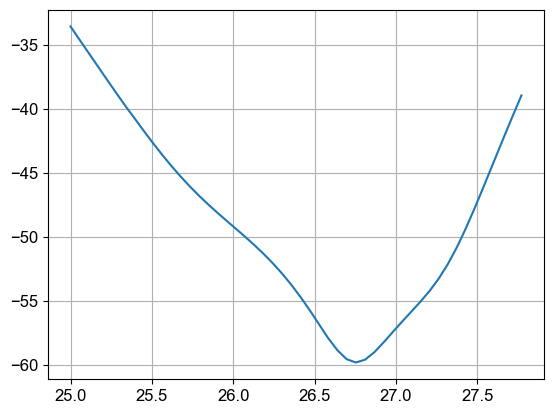

In [ ]:
rasr.calc_rasr()
print(rasr.rasr_parcial.shape)
plt.figure()
plt.plot(rasr.inc_v, 10*np.log10(rasr.rasr_total[0]))
plt.grid(True)